
# Uber Trip Analysis — Machine Learning Pipeline

**File used (Colab path):** `/content/Uber-Jan-Feb-FOIL.csv`

This notebook includes a complete, minimal and well-commented pipeline you can run on Google Colab:
- Data loading & inspection
- Preprocessing & hourly aggregation
- Exploratory Data Analysis (plots)
- Feature engineering (time features, lags)
- Model training (Random Forest) with time-based split
- Evaluation, plots, and saving a trained model

Run the cells in order. If you run this in Colab, make sure the CSV is present at `/content/Uber-Jan-Feb-FOIL.csv` (you said it is).


In [10]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import os
print("libraries loaded")


libraries loaded


In [11]:
DATA_PATH = "/content/Uber-Jan-Feb-FOIL.csv"

print("Expecting data at:", DATA_PATH)
print("Exists?", os.path.exists(DATA_PATH))

df = pd.read_csv(DATA_PATH, low_memory=False)
print("\nInitial shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Expecting data at: /content/Uber-Jan-Feb-FOIL.csv
Exists? True

Initial shape: (354, 4)
Columns: ['dispatching_base_number', 'date', 'active_vehicles', 'trips']


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [12]:
datetime_col = None
for c in df.columns:
    if 'date' in c.lower() or 'time' in c.lower():
        datetime_col = c
        break

if datetime_col is None:
    for c in df.columns:
        try:
            pd.to_datetime(df[c])
            datetime_col = c
            break
        except Exception:
            continue

if datetime_col is None:
    raise ValueError("Couldn't find a datetime column automatically. Columns: {}".format(df.columns))

print("Using datetime column:", datetime_col)
df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
print("Parsed datetimes: {} nulls".format(df[datetime_col].isna().sum()))

# Drop rows without datetime
df = df.dropna(subset=[datetime_col]).copy()

if 'trips' in df.columns:
    df['pickup_hour'] = df[datetime_col].dt.floor('H')
    hourly = df.groupby('pickup_hour')['trips'].sum().reset_index(name='count')
else:
    df['pickup_hour'] = df[datetime_col].dt.floor('H')
    hourly = df.groupby('pickup_hour').size().reset_index(name='count')

# Ensure continuous hourly index (fills missing hours with 0)
hourly = hourly.set_index('pickup_hour').asfreq('H', fill_value=0).reset_index()
print("Hourly series shape:", hourly.shape)
hourly.head(24)


Using datetime column: date
Parsed datetimes: 0 nulls
Hourly series shape: (1393, 2)


/tmp/ipython-input-3100715992.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_hour'] = df[datetime_col].dt.floor('H')
/tmp/ipython-input-3100715992.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = hourly.set_index('pickup_hour').asfreq('H', fill_value=0).reset_index()


,pickup_hour,count
0,2015-01-01 00:00:00,56437
1,2015-01-01 01:00:00,0
2,2015-01-01 02:00:00,0
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,0
5,2015-01-01 05:00:00,0
6,2015-01-01 06:00:00,0
7,2015-01-01 07:00:00,0
8,2015-01-01 08:00:00,0
9,2015-01-01 09:00:00,0


count      1393.000000
mean       2964.989232
std       14469.156797
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      100915.000000
Name: count, dtype: float64


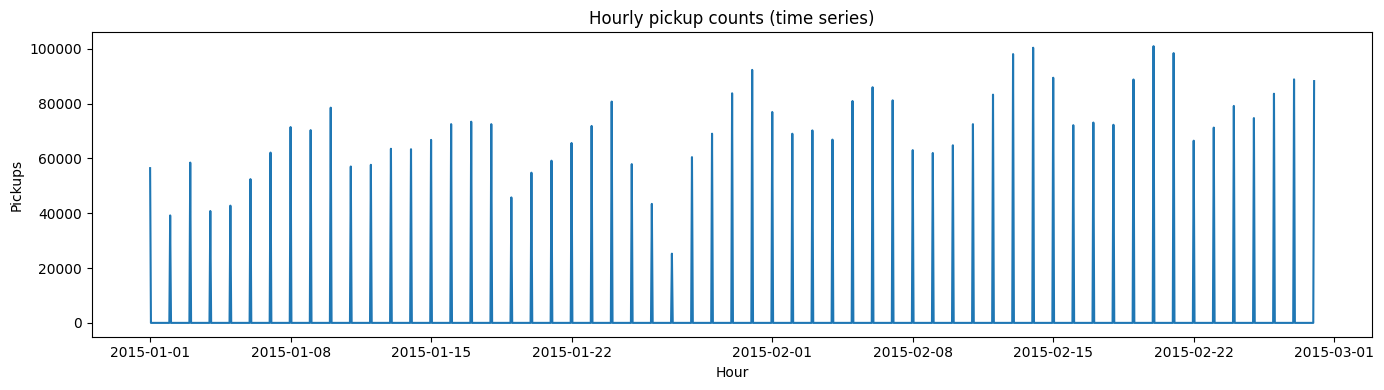

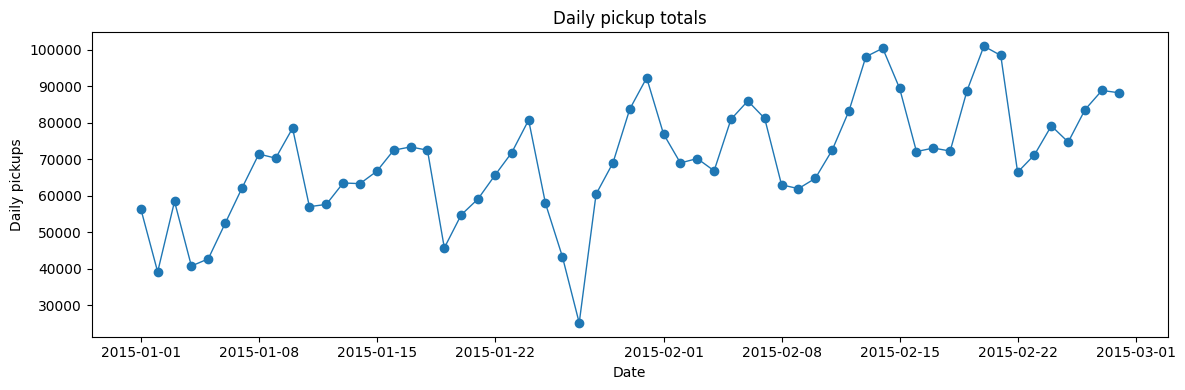

In [13]:

# Quick EDA: time series and basic stats
print(hourly['count'].describe())

plt.figure(figsize=(14,4))
plt.plot(hourly['pickup_hour'], hourly['count'])
plt.title('Hourly pickup counts (time series)')
plt.xlabel('Hour')
plt.ylabel('Pickups')
plt.tight_layout()
plt.show()

# Plot daily totals to see weekday patterns
daily = hourly.set_index('pickup_hour').resample('D')['count'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily['pickup_hour'], daily['count'], marker='o', linewidth=1)
plt.title('Daily pickup totals')
plt.xlabel('Date')
plt.ylabel('Daily pickups')
plt.tight_layout()
plt.show()


In [14]:

# Feature engineering
hourly['hour'] = hourly['pickup_hour'].dt.hour
hourly['dayofweek'] = hourly['pickup_hour'].dt.dayofweek  # Monday=0
hourly['is_weekend'] = hourly['dayofweek'].isin([5,6]).astype(int)
hourly['month'] = hourly['pickup_hour'].dt.month
hourly['day'] = hourly['pickup_hour'].dt.day
hourly['weekofyear'] = hourly['pickup_hour'].dt.isocalendar().week.astype(int)

# Lag features
hourly['lag_1'] = hourly['count'].shift(1).fillna(0)
hourly['rolling_24_mean'] = hourly['count'].rolling(window=24, min_periods=1).mean().shift(1).fillna(0)

hourly = hourly.dropna().reset_index(drop=True)
hourly.head()


,pickup_hour,count,hour,dayofweek,is_weekend,month,day,weekofyear,lag_1,rolling_24_mean
0,2015-01-01 00:00:00,56437,0,3,0,1,1,1,0.0,0.000000
1,2015-01-01 01:00:00,0,1,3,0,1,1,1,56437.0,56437.000000
2,2015-01-01 02:00:00,0,2,3,0,1,1,1,0.0,28218.500000
3,2015-01-01 03:00:00,0,3,3,0,1,1,1,0.0,18812.333333
4,2015-01-01 04:00:00,0,4,3,0,1,1,1,0.0,14109.250000


In [15]:
# Modeling: predict hourly count using engineered features

features = ['hour', 'dayofweek', 'is_weekend', 'month', 'lag_1', 'rolling_24_mean', 'weekofyear', 'day']
X = hourly[features]
y = hourly['count']

# Time-based split (no shuffling): first 70% train, rest test
split_idx = int(0.7 * len(hourly))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Train RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
# Fix: Calculate RMSE by taking the square root of MSE, as 'squared' argument is not supported
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_train = rf.score(X_train, y_train)
r2_test = rf.score(X_test, y_test)

print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2_train: {r2_train:.4f} | R2_test: {r2_test:.4f}")


Train shape: (975, 8) Test shape: (418, 8)
MAE: 615.8685 | RMSE: 3255.0495 | R2_train: 0.9955 | R2_test: 0.9637


           feature  importance
0             hour    0.956066
5  rolling_24_mean    0.026026
7              day    0.008045
1        dayofweek    0.006790
6       weekofyear    0.002554
2       is_weekend    0.000328
3            month    0.000191
4            lag_1    0.000000


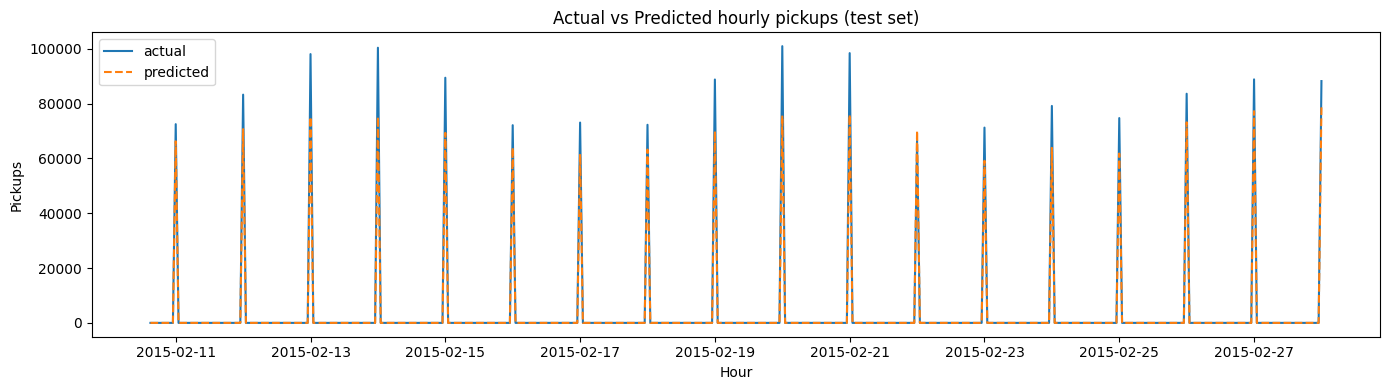

,pickup_hour,actual,predicted
0,2015-02-10 15:00:00,0,0.00
1,2015-02-10 16:00:00,0,0.00
2,2015-02-10 17:00:00,0,0.00
3,2015-02-10 18:00:00,0,0.00
4,2015-02-10 19:00:00,0,0.00
5,2015-02-10 20:00:00,0,0.00
6,2015-02-10 21:00:00,0,0.00
7,2015-02-10 22:00:00,0,0.00
8,2015-02-10 23:00:00,0,0.00
9,2015-02-11 00:00:00,72470,66230.06


In [16]:

# Feature importances
fi = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print(fi)

# Plot actual vs predicted (test set)
plt.figure(figsize=(14,4))
plt.plot(hourly['pickup_hour'].iloc[split_idx:], y_test.values, label='actual')
plt.plot(hourly['pickup_hour'].iloc[split_idx:], y_pred, label='predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted hourly pickups (test set)')
plt.xlabel('Hour')
plt.ylabel('Pickups')
plt.tight_layout()
plt.show()

# Show a small compare table
compare = pd.DataFrame({
    'pickup_hour': hourly['pickup_hour'].iloc[split_idx:].values,
    'actual': y_test.values,
    'predicted': np.round(y_pred,2)
})
compare.head(10)


In [17]:

# Save trained model to Colab filesystem
model_path = "/content/uber_hourly_rf_joblib.pkl"
joblib.dump(rf, model_path)
print("Saved model to:", model_path)

# Next steps & tips (text output cell)
print("""

Next steps & tips:
- Try gradient boosting (XGBoost/LightGBM) for better accuracy.
- Add weather data, local events, or holidays as external regressors.
- If you have pickup lat/lon for each trip, cluster into zones (k-means) and model per-zone.
- For real time demand forecasting, consider using Prophet/ARIMA for the time-series component plus exogenous variables.
""")


Saved model to: /content/uber_hourly_rf_joblib.pkl


Next steps & tips:
- Try gradient boosting (XGBoost/LightGBM) for better accuracy.
- Add weather data, local events, or holidays as external regressors.
- If you have pickup lat/lon for each trip, cluster into zones (k-means) and model per-zone.
- For real time demand forecasting, consider using Prophet/ARIMA for the time-series component plus exogenous variables.



Notebook generated programmatically on 2025-11-25 09:59:24 UTC